<span style="color:red; font-weight:bold; font-size:2em; font-style:italic">RAG</span>

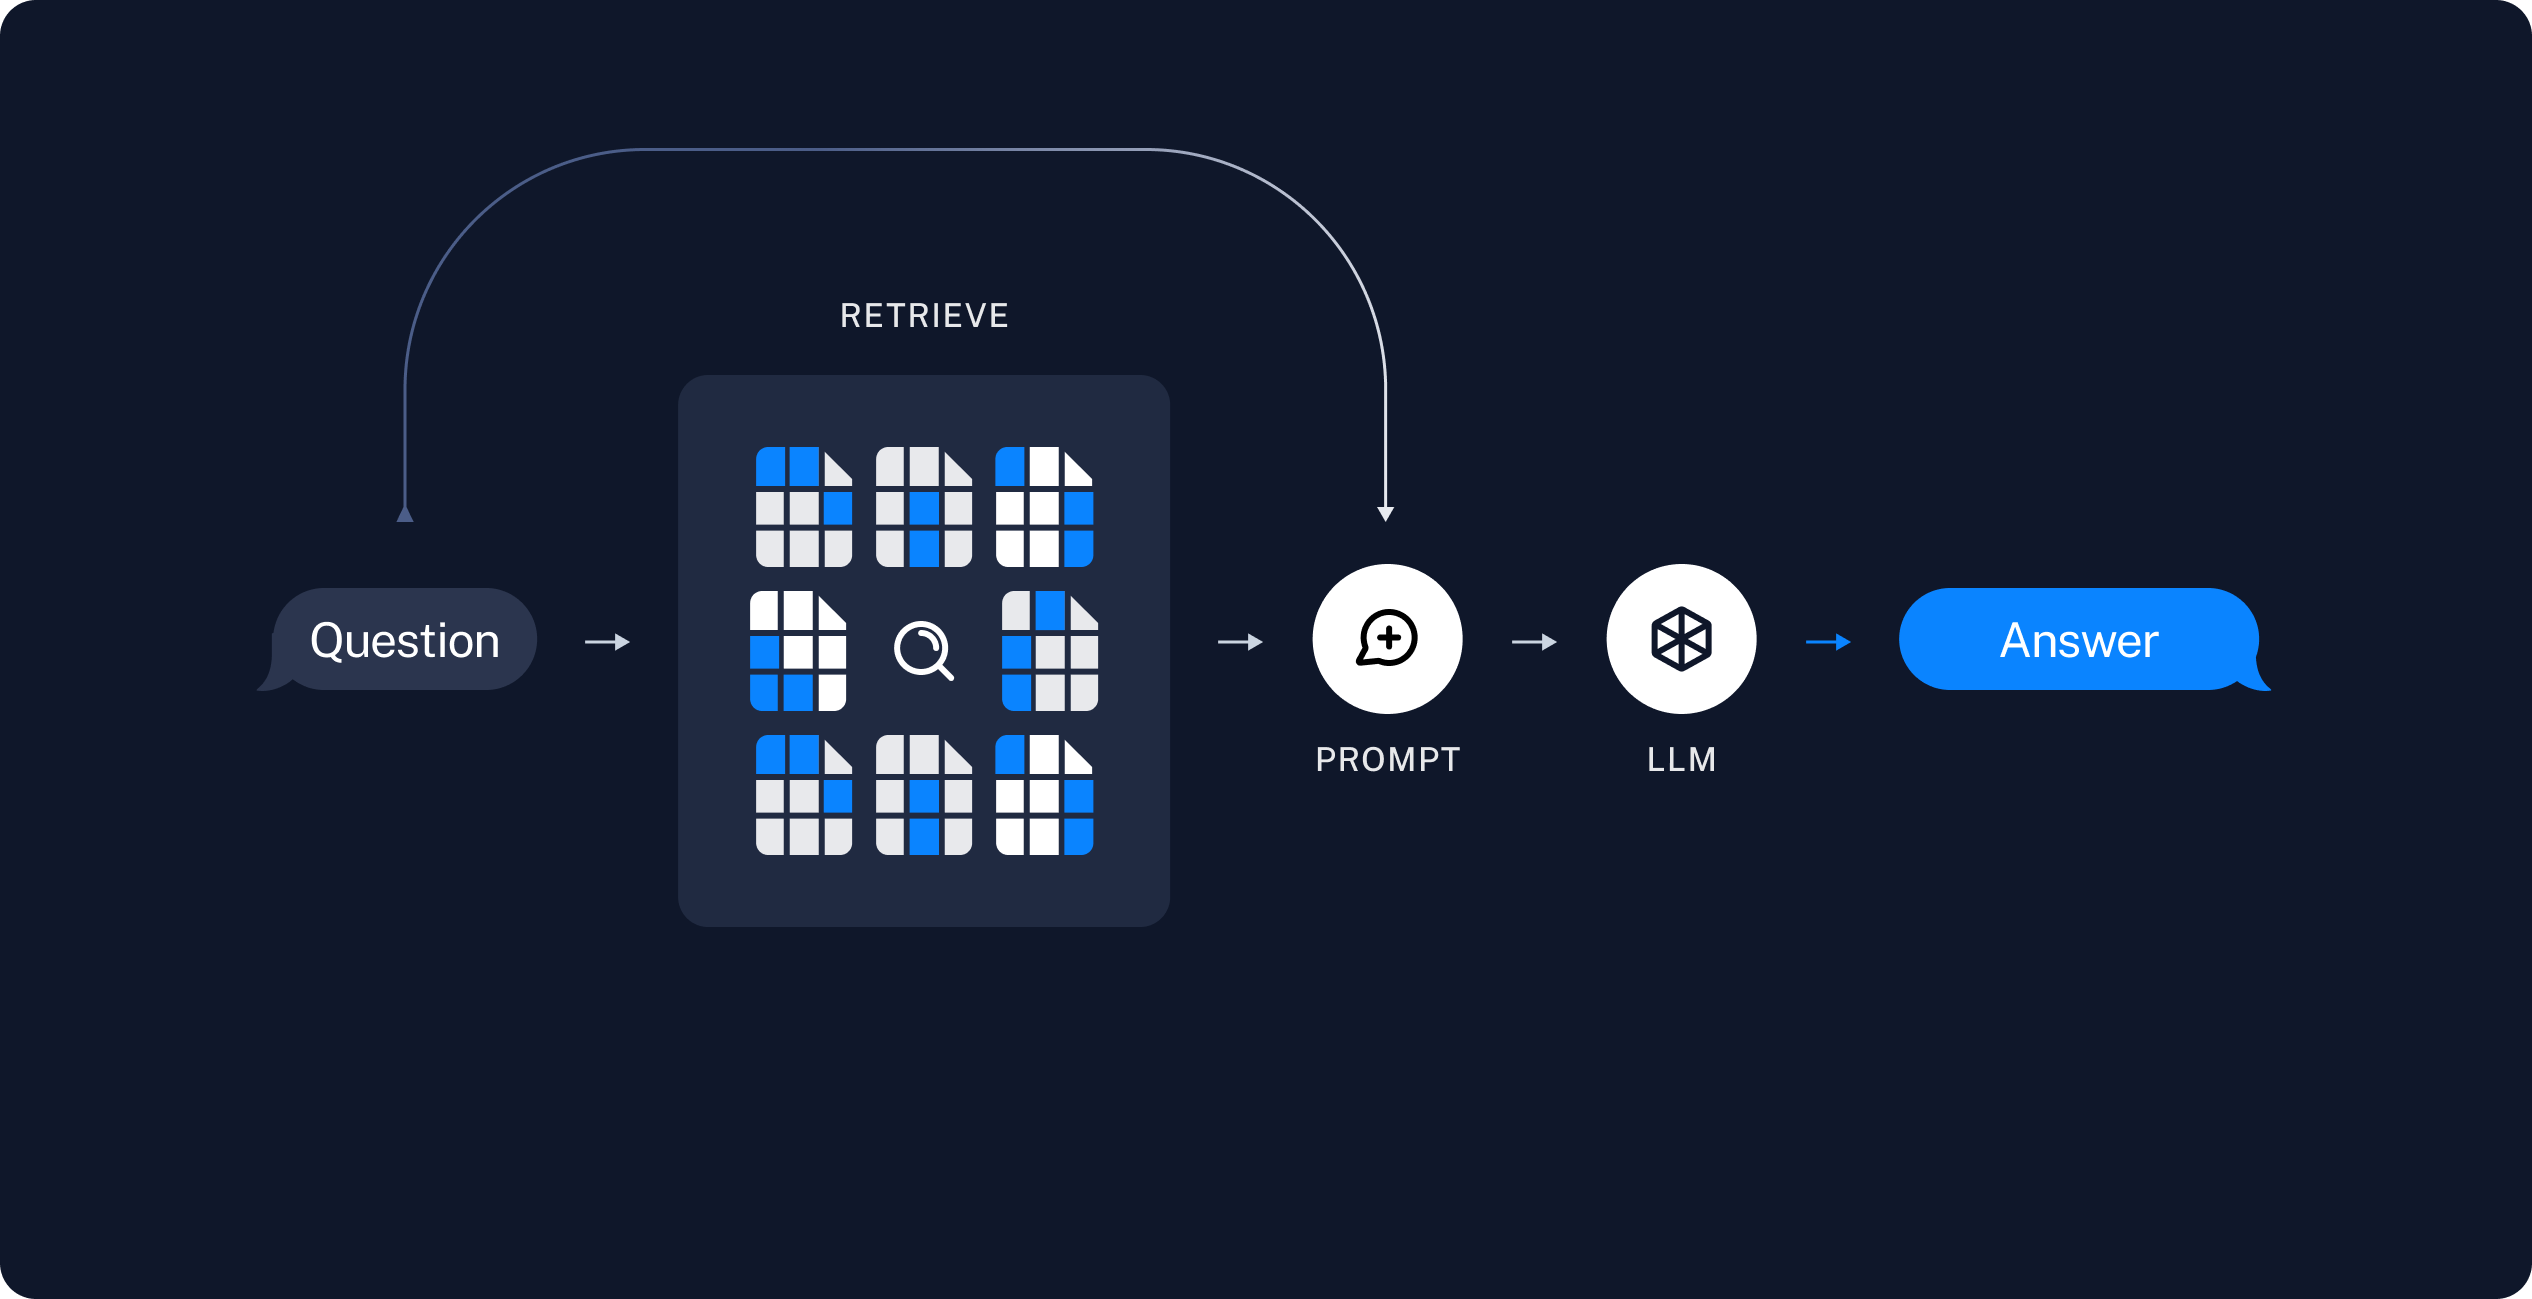

In [33]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

/home/jorge/TFG/RAG/venv/bin/python: No module named pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [34]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

#### LangsMith

#### LLM

In [35]:
import getpass
import os

if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("llama-3.1-8b-instant", model_provider="groq", temperature=0.9)

In [36]:
from groq import Groq
import os

client = Groq(api_key=os.environ["GROQ_API_KEY"])

models = client.models.list()

for model in models.data:
    print(model.id)


groq/compound-mini
meta-llama/llama-4-maverick-17b-128e-instruct
qwen/qwen3-32b
meta-llama/llama-prompt-guard-2-86m
moonshotai/kimi-k2-instruct
moonshotai/kimi-k2-instruct-0905
whisper-large-v3-turbo
groq/compound
meta-llama/llama-prompt-guard-2-22m
whisper-large-v3
meta-llama/llama-4-scout-17b-16e-instruct
allam-2-7b
playai-tts
playai-tts-arabic
meta-llama/llama-guard-4-12b
llama-3.3-70b-versatile
openai/gpt-oss-120b
llama-3.1-8b-instant
openai/gpt-oss-20b


#### Embedding model

In [37]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [38]:
os.environ["LANGSMITH_TRACING"] = os.environ.get("LANGSMITH_TRACING", "true") 
# Now checks os.environ *after* load_dotenv() has run
if os.environ["LANGSMITH_TRACING"] == "true" and not os.environ.get("LANGSMITH_API_KEY"):
    print("LANGSMITH_TRACING is enabled, but LANGSMITH_API_KEY was not found in environment or .env file.")
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter your LANGSMITH_API_KEY: ")

LANGSMITH_TRACING is enabled, but LANGSMITH_API_KEY was not found in environment or .env file.


#### Vector stores

Stores embedded data and performs similarity search.

In-memory vector stores are fast but not persistent, while persistent vector stores are slower but can handle larger datasets.

In [39]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [40]:
import bs4
from langchain_classic import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

### API Reference

In [41]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])


Task Decomposition is a process to break down a complex task into multiple smaller and simpler steps. This can be done through simple prompting, task-specific instructions, or human inputs. It is also a key component in the HuggingGPT system, where LLM parses the user request into multiple tasks.

As an AI assistant, I analyzed the request to explain Task Decomposition. I considered the input from the user, which was not provided. I formed the task process as Task Planning: Explanation of Task Decomposition, and Task Execution: The explanation provided above is the result.


In [42]:
from openai import OpenAI

client = OpenAI()  # This automatically uses your OPENAI_API_KEY env variable
models = client.models.list()

for m in models.data[:5]:  # show just a few
    print(m.id)


gpt-3.5-turbo
gpt-5-search-api-2025-10-14
gpt-audio-mini-2025-10-06
gpt-5-search-api
sora-2


## RAG Details

### Indexing

In [43]:
from dotenv import load_dotenv 
load_dotenv()  # <-- ADDED THIS CALL

True

In [44]:
import bs4

from langchain_community.document_loaders import WebBaseLoader 

# Keep the main content — e.g. paragraphs, headings, intro sections
bs4_strainer = bs4.SoupStrainer(
    name=["p", "h1", "h2", "h3", "h4"],  # paragraphs + headings
    class_=None  # allow default classes (Wikipedia doesn’t use “post-content” etc)
)

pages = [
    "https://en.wikipedia.org/wiki/Nico_Williams",
    "https://en.wikipedia.org/wiki/Athletic_Bilbao",
    "https://en.wikipedia.org/wiki/Spain_national_football_team",
    "https://en.wikipedia.org/wiki/I%C3%B1aki_Williams"
]

loader = WebBaseLoader(
    web_paths=pages,
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 4
print(f"Total characters: {len(docs[0].page_content)}")


Total characters: 9106


In [45]:
print(docs[0].page_content[:4440])

Nicholas Williams Arthuer (born 12 July 2002) is a Spanish professional footballer who plays as a winger for La Liga club Athletic Bilbao and the Spain national team. He is recognised for his speed and dribbling skills.[2]
Joining Athletic Bilbao's youth academy in 2013, he was promoted to the reserve team in 2020 and to the first team a year later, becoming a teammate of elder brother Iñaki Williams, with both winning the 2023–24 Copa del Rey.
Williams debuted for Spain's senior side in 2022. He was a member of their 2022 FIFA World Cup and UEFA Euro 2024 squads, scoring and being named man of the match in the final of the latter, as Spain won the tournament.
Club careerBorn in Pamplona, Navarre, Williams joined the youth academy of Athletic Bilbao in 2013 from hometown side CA Osasuna.[3] He began his senior career with the club's farm team, Basconia, during the 2019–20 season.[4]
On 11 May 2020, Williams was promoted to the reserve team in the Segunda División B.[5] He made his firs

Spliting Documents
Our loaded document is over 42k characters which is too long to fit into the context window of many models. Even for those models that could fit the full post in their context window, models can struggle to find information in very long inputs.

To handle this we’ll split the Document into chunks for embedding and vector storage. This should help us retrieve only the most relevant parts of the blog post at run time based on embedding similarity.

As in the semantic search tutorial, we use a **RecursiveCharacterTextSplitter**, which will recursively split the document using common separators like new lines until each chunk is the appropriate size. This is the recommended text splitter for generic text use cases.



```python
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

In [46]:

from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 46 sub-documents.


### Storing documents

Now we need to index our 66 text chunks so that we can search over them at runtime. Following the semantic search tutorial, our approach is to embed the contents of each document split and insert these embeddings into a vector store. Given an input query, we can then use vector search to retrieve relevant documents.

Compute document embeddings to compute similarity with the input query.

In [47]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3]) # Print first 3 inserted document IDs

# Index IDs are computed as the hash of the document content each time the document is inserted

['6aca680d-e3c5-4391-bb95-5589c3754844', '10c8eb4c-a341-409b-95da-c12eaf4d8238', '0304a9c3-0a2e-4807-8c53-2134b8ddb761']


**Embeddings**: Wrapper around a text embedding model, used for converting text to embeddings.

- Docs: Detailed documentation on how to use embeddings.
- Integrations: 30+ integrations to choose from.
- Interface: API reference for the base interface.


**VectorStore**: Wrapper around a vector database, used for storing and querying embeddings.

- Docs: Detailed documentation on how to use vector stores.
- Integrations: 40+ integrations to choose from.
- Interface: API reference for the base interface.

### RAG
We want to create a simple application that takes a user question, searches for documents relevant to that question, passes the retrieved documents and initial question to a model, and returns an answer.

In [48]:
## RAG

from langchain import hub
# repository of prompt templates, chains, and workflows that you can reuse instead of writing from scratch.

# retrieve prompts from hub
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

ImportError: cannot import name 'hub' from 'langchain' (/home/jorge/TFG/RAG/venv/lib/python3.10/site-packages/langchain/__init__.py)

In [ ]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

# State lets you define the shape of the data your application will pass between steps.
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

We'll use LangGraph to tie together the retrieval and generation steps into a single application. This will bring a number of benefits:

- We can define our application logic once and automatically support multiple invocation modes, including streaming, async, and batched calls.
- We get streamlined deployments via LangGraph Platform.
- LangSmith will automatically trace the steps of our application together.
- We can easily add key features to our application, including persistence and human-in-the-loop approval, with minimal code changes.

To use LangGraph, we need to define three things:

The state of our application;
The nodes of our application (i.e., application steps);
The "control flow" of our application (e.g., the ordering of the steps).
State:
The state of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a TypedDict, but can also be a Pydantic BaseModel.

For a simple RAG application, we can just keep track of the input question, retrieved context, and generated answer:

Nodes: application steps

In [ ]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"]) # retrieve relevant documents
    return {"context": retrieved_docs} 


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

**Control flow**

Finally, we compile our application into a single graph object. In this case, we are just connecting the retrieval and generation steps into a single sequence.

In [ ]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

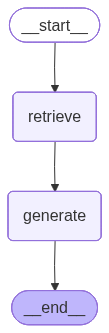

In [ ]:
# Visualize application

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## USE

In [ ]:
result = graph.invoke({"question": "Talk about world cup 2010"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='9f1cbddc-9551-4365-a94f-1025f6e09f57', metadata={'source': 'https://en.wikipedia.org/wiki/Nico_Williams', 'start_index': 4337, 'section': 'beginning'}, page_content='In the 2024–25 season, Williams\'s statistical return was similar to the previous campaign,[30][31] although his performances were periodically affected by injury issues and he was assessed to have "not had a particularly standout season",[32] with the club\'s strong form in La Liga (in which they qualified for the UEFA Champions League for the first time in a decade) largely due to a strong defence, while Oihan Sancet was the most effective attacking component. Williams made his first appearances in continental competition, scoring five times including decisive goals in knockout ties against Roma and Rangers and being named in the team of the tournament as Athletic progressed to the semi-finals of the UEFA Europa League, but they were unsuccessful in their efforts to reach the final (to be staged at

In [ ]:
from openai import OpenAI

client = OpenAI()  # This automatically uses your OPENAI_API_KEY env variabl e
models = client.models.list()

for m in models.data[:5]:  # show just a few
    print(m.id)


gpt-3.5-turbo
gpt-5-codex
gpt-5-nano-2025-08-07
gpt-5-nano
gpt-audio-2025-08-28


## Go deeper

In [ ]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://en.wikipedia.org/wiki/Nico_Williams',
 'start_index': 0,
 'section': 'beginning'}

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

In [ ]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

Add a step to our LangGraph application to generate a query from the user's raw input:

In [ ]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

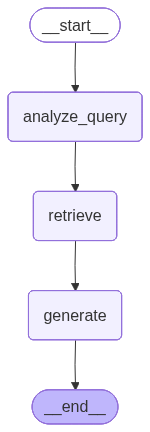

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
for step in graph.stream(
    {"question": "Como fue la final de copa de 2024?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'copa de 2024 final', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='9f1cbddc-9551-4365-a94f-1025f6e09f57', metadata={'source': 'https://en.wikipedia.org/wiki/Nico_Williams', 'start_index': 4337, 'section': 'beginning'}, page_content='In the 2024–25 season, Williams\'s statistical return was similar to the previous campaign,[30][31] although his performances were periodically affected by injury issues and he was assessed to have "not had a particularly standout season",[32] with the club\'s strong form in La Liga (in which they qualified for the UEFA Champions League for the first time in a decade) largely due to a strong defence, while Oihan Sancet was the most effective attacking component. Williams made his first appearances in continental competition, scoring five times including decisive goals in knockout ties against Roma and Rangers and being named in the team of the tournament as Athletic progressed to t

In [ ]:
result = graph.invoke({"question": "Detail 2023-24 final Copa del Rey"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='9f1cbddc-9551-4365-a94f-1025f6e09f57', metadata={'source': 'https://en.wikipedia.org/wiki/Nico_Williams', 'start_index': 4337, 'section': 'beginning'}, page_content='In the 2024–25 season, Williams\'s statistical return was similar to the previous campaign,[30][31] although his performances were periodically affected by injury issues and he was assessed to have "not had a particularly standout season",[32] with the club\'s strong form in La Liga (in which they qualified for the UEFA Champions League for the first time in a decade) largely due to a strong defence, while Oihan Sancet was the most effective attacking component. Williams made his first appearances in continental competition, scoring five times including decisive goals in knockout ties against Roma and Rangers and being named in the team of the tournament as Athletic progressed to the semi-finals of the UEFA Europa League, but they were unsuccessful in their efforts to reach the final (to be staged at